# Fashion Recommendation System

## Embedding model - ResNet50

Reference - https://towardsdatascience.com/building-a-personalized-real-time-fashion-collection-recommender-22dc90c150cb

In [1]:
# Imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from fastai.vision import *
from fastai.metrics import accuracy, top_k_accuracy
from annoy import AnnoyIndex
import zipfile
import time
%matplotlib inline

In [2]:
# Train with GPU if available
train_on_gpu = torch.cuda.is_available()
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ... To use GPU, go under edit > notebook settings')
else:
    print('CUDA is available!  Training on GPU ...')
    print(gpu_info)

CUDA is available!  Training on GPU ...
Sat Nov 27 10:18:58 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.100      Driver Version: 440.100      CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 1080    Off  | 00000000:01:00.0  On |                  N/A |
|  0%   40C    P5     9W / 180W |    256MiB /  8116MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  GeForce GTX 1080    Off  | 00000000:02:00.0 Off |                  N/A |
|  0%   36C    P8     9W / 180W |     12MiB /  8119MiB |      0%      Default |
+-------------------------------+---------------

### Data Preprocessing

In [3]:
# Meta data
category_list = []
image_path_list = []
data_type_list = []
# category names
with open('/media/pavan/datasets/deepfashion/Anno/list_category_cloth.txt', 'r') as f:
    for i, line in enumerate(f.readlines()):
        if i > 1:
            category_list.append(line.split(' ')[0])

# category map
with open('/media/pavan/datasets/deepfashion/Anno/list_category_img.txt', 'r') as f:
    for i, line in enumerate(f.readlines()):
        if i > 1:
            image_path_list.append([word.strip() for word in line.split(' ') if len(word) > 0])


# train, valid, test
with open('/media/pavan/datasets/deepfashion/Eval/list_eval_partition.txt', 'r') as f:
    for i, line in enumerate(f.readlines()):
        if i > 1:
            data_type_list.append([word.strip() for word in line.split(' ') if len(word) > 0])

In [4]:
# Combining useful meta data
data_df = pd.DataFrame(image_path_list, columns=['image_path', 'category_number'])
data_df['category_number'] = data_df['category_number'].astype(int)
data_df = data_df.merge(pd.DataFrame(data_type_list, columns=['image_path', 'dataset_type']), on='image_path')
data_df['category'] = data_df['category_number'].apply(lambda x: category_list[int(x) - 1])
data_df = data_df.drop('category_number', axis=1)
data_df.head()

,image_path,dataset_type,category
0,img/Sheer_Pleated-Front_Blouse/img_00000001.jpg,train,Blouse
1,img/Sheer_Pleated-Front_Blouse/img_00000002.jpg,train,Blouse
2,img/Sheer_Pleated-Front_Blouse/img_00000003.jpg,val,Blouse
3,img/Sheer_Pleated-Front_Blouse/img_00000004.jpg,train,Blouse
4,img/Sheer_Pleated-Front_Blouse/img_00000005.jpg,test,Blouse


In [5]:
# Total images in DeepFashion
len(data_df)

289222

In [6]:
# Split count
data_df[['image_path','dataset_type']].groupby('dataset_type').count()

,image_path
dataset_type,
test,40000
train,209222
val,40000


In [7]:
# Number of categories present in dataset
len(data_df.category.unique())

46

<AxesSubplot:xlabel='category'>

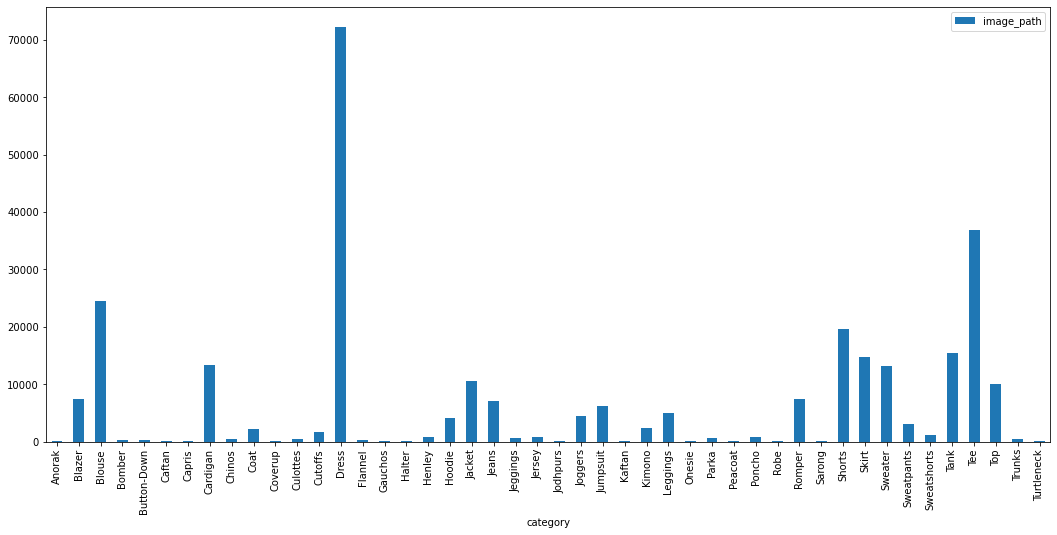

In [111]:
category_cnt = data_df[['image_path','category']].groupby('category').count()
category_cnt.plot.bar(figsize=[18,8])

## Convert images to embeddings using Fastai library

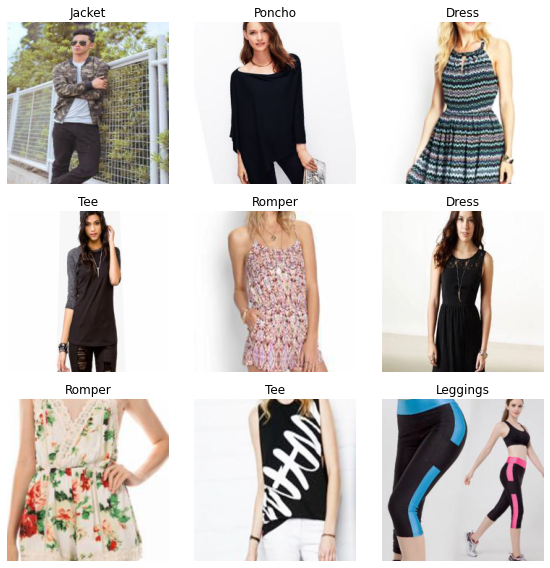

In [112]:
root_path = '/media/pavan/datasets/deepfashion/Img/'
train_image_list = ImageList.from_df(df=data_df, path=root_path, cols='image_path').split_by_idxs(
    (data_df[data_df['dataset_type']=='train'].index),
    (data_df[data_df['dataset_type']=='val'].index)).label_from_df(cols='category')
test_image_list = ImageList.from_df(df=data_df[data_df['dataset_type'] == 'test'], path=root_path, cols='image_path')

data = train_image_list.transform(get_transforms(), size=224).databunch(bs=128).normalize(imagenet_stats)
data.add_test(test_image_list)
data.show_batch(rows=3, figsize=(8,8))

### Conduct Transfer Learning from ResNet50

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /home/pavan/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,accuracy,top_k_accuracy,top_k_accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.20E-03
Min loss divided by 10: 1.00E-02


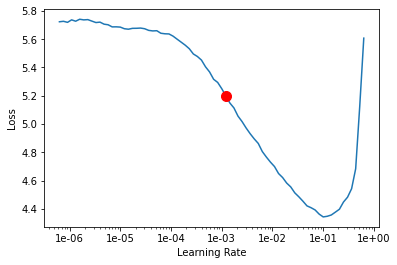

In [11]:
def train_model(data, pretrained_model, model_metrics):
    learner = cnn_learner(data, pretrained_model, metrics=model_metrics)
    learner.model = torch.nn.DataParallel(learner.model)
    learner.lr_find()
    learner.recorder.plot(suggestion=True)
    return learner

pretrained_model = models.resnet50

model_metrics = [accuracy, partial(top_k_accuracy, k=1), partial(top_k_accuracy, k=5)]
learner = train_model(data, pretrained_model, model_metrics)

In [12]:
learner.fit_one_cycle(10, max_lr=1e-03)

epoch,train_loss,valid_loss,accuracy,top_k_accuracy,top_k_accuracy,time
0,1.855987,1.457606,0.593250,0.593250,0.888575,12:47
1,1.451651,1.255270,0.633250,0.633250,0.911925,12:50
2,1.372181,1.220234,0.641175,0.641175,0.916075,12:50
3,1.276413,1.189788,0.650850,0.650850,0.921325,12:49
4,1.252712,1.156708,0.659100,0.659100,0.924325,12:49
5,1.234690,1.132334,0.666950,0.666950,0.926750,12:49
6,1.202142,1.116403,0.670725,0.670725,0.929825,13:01
7,1.156172,1.099955,0.676250,0.676250,0.932300,13:45
8,1.153008,1.093334,0.678325,0.678325,0.933025,13:44
9,1.139012,1.093974,0.678375,0.678375,0.932600,13:44


## Evaluate Model 

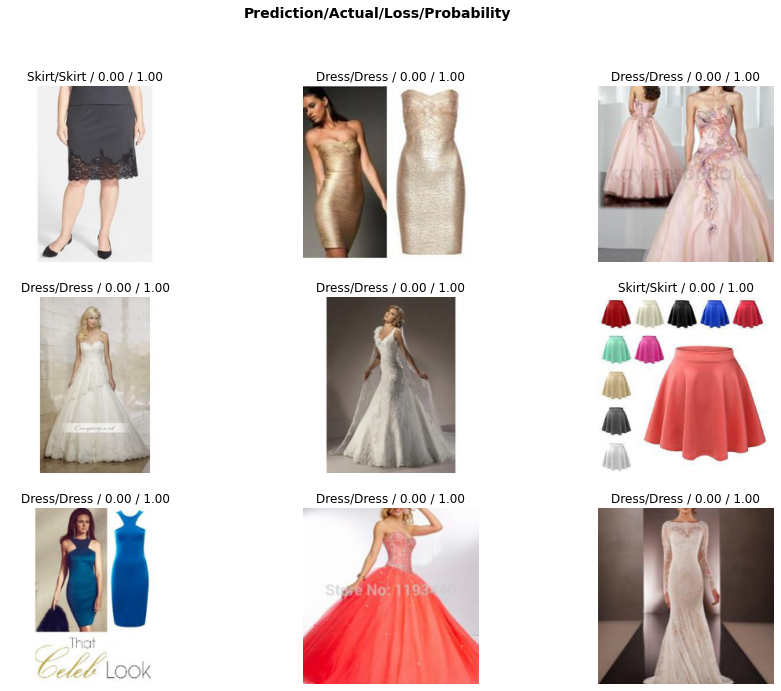

In [13]:
interp = ClassificationInterpretation.from_learner(learner)
interp.plot_top_losses(9, largest=False, figsize=(15,11), heatmap_thresh=5)

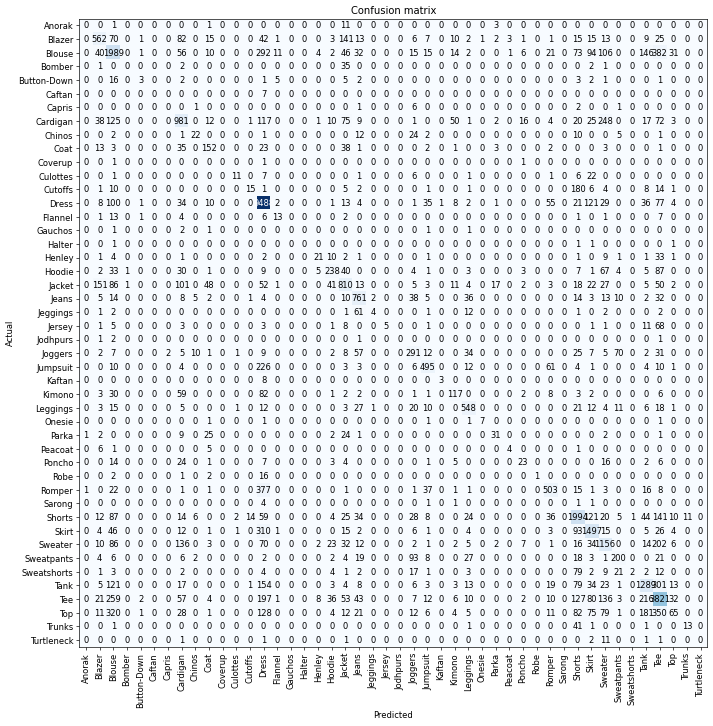

In [14]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [113]:
learner.save('/home/pavan/code/sjsu/256/project/resnet50-fashion')

In [16]:
learner.model.module

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): Conv2d(64, 256

## Using Fastai hooks to retrieve image embeddings

In [11]:
class SaveFeatures():
    features=None
    def __init__(self, m): 
        self.hook = m.register_forward_hook(self.hook_fn)
        self.features = None
    def hook_fn(self, module, input, output): 
        out = output.detach().cpu().numpy()
        if isinstance(self.features, type(None)):
            self.features = out
        else:
            self.features = np.row_stack((self.features, out))
    def remove(self): 
        self.hook.remove()

In [12]:
def load_learner(data, pretrained_model, model_metrics, model_path):
    learner = cnn_learner(data, pretrained_model, metrics=model_metrics)
    learner.model = torch.nn.DataParallel(learner.model)
    learner = learner.load(model_path)
    return learner

pretrained_model = models.resnet50 

model_metrics = [accuracy, partial(top_k_accuracy, k=1), partial(top_k_accuracy, k=5)]


model_path = "/home/pavan/code/sjsu/256/project/resnet50-fashion"
loaded_learner = load_learner(data, pretrained_model, model_metrics, model_path)

In [13]:
loaded_learner.model.module[-1][-3]

BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

In [14]:
# takes time to populate the embeddings for each image
# Get 2nd last layer of the model that stores the embedding for the image representations
# the last linear layer is the output layer.
saved_features = SaveFeatures(loaded_learner.model.module[-1][-3])
train_embed = loaded_learner.get_preds(data.train_ds)
val_embed = loaded_learner.get_preds(data.valid_ds)

In [16]:
saved_features.remove()

In [20]:
# prepare the data for generating recommendations (exlcude test data)
# get the embeddings from trained model
img_path = [str(x) for x in (list(data.train_ds.items) +list(data.valid_ds.items))]
label = [data.classes[x] for x in (list(data.train_ds.y.items) +list(data.valid_ds.y.items))]
label_id = [x for x in (list(data.train_ds.y.items) +list(data.valid_ds.y.items))]
data_df_ouput = pd.DataFrame({'img_path': img_path, 'label': label, 'label_id': label_id})[:len(saved_features.features)]
data_df_ouput['embeddings'] = np.array(saved_features.features).tolist()
data_df_ouput

,img_path,label,label_id,embeddings
0,/media/pavan/datasets/deepfashion/Img/img/Shee...,Blouse,2,"[0.18593111634254456, -0.3709107041358948, -0...."
1,/media/pavan/datasets/deepfashion/Img/img/Shee...,Blouse,2,"[-0.35224926471710205, 0.2348317801952362, 0.1..."
2,/media/pavan/datasets/deepfashion/Img/img/Shee...,Blouse,2,"[1.6913343667984009, -0.3709107041358948, -0.1..."
3,/media/pavan/datasets/deepfashion/Img/img/Shee...,Blouse,2,"[-0.35224926471710205, -0.3709107041358948, -0..."
4,/media/pavan/datasets/deepfashion/Img/img/Shee...,Blouse,2,"[-0.06259311735630035, -0.3709107041358948, -0..."
...,...,...,...,...
214081,/media/pavan/datasets/deepfashion/Img/img/Slou...,Tank,41,"[0.2819516658782959, -0.3709107041358948, 0.13..."
214082,/media/pavan/datasets/deepfashion/Img/img/Slou...,Tank,41,"[0.4297846257686615, -0.08945290744304657, 0.5..."
214083,/media/pavan/datasets/deepfashion/Img/img/Slou...,Tank,41,"[-0.35224926471710205, -0.3709107041358948, 0...."
214084,/media/pavan/datasets/deepfashion/Img/img/Slou...,Tank,41,"[-0.35224926471710205, -0.3229467570781708, 0...."


# Use Approximate Nearest Neighbors to obtain most similar images

In [137]:
# Using Spotify's Annoy
def get_similar_images_annoy(annoy_tree, img_index, number_of_items=9):
    start = time.time()
    img_id, img_label  = data_df_ouput.iloc[img_index, [0, 1]]
    similar_img_ids = annoy_tree.get_nns_by_item(img_index, number_of_items+1)
    end = time.time()
    print(f'{(end - start) * 1000} ms')
    # ignore first item as it is always target image
    return img_id, img_label, data_df_ouput.iloc[similar_img_ids[0:]]

# Display image(s)
def show_similar_images(similar_images_df, fig_size=[6, 6], hide_labels=False):
    if hide_labels:
        category_list = []
        for i in range(len(similar_images_df)):
            # replace category with blank so it wont show in display
            category_list.append(CategoryList(similar_images_df['label_id'].values*0,
                                              [''] * len(similar_images_df)).get(i))
    else:
        category_list = [loaded_learner.data.train_ds.y.reconstruct(y) for y in similar_images_df['label_id']]
    return loaded_learner.data.show_xys([open_image(img_id) for img_id in similar_images_df['img_path']],
                                category_list, figsize=fig_size)

In [115]:
# more tree = better approximation
ntree = 400
#"angular", "euclidean", "manhattan", "hamming", or "dot"
metric_choice = 'hamming'

annoy_tree = AnnoyIndex(len(data_df_ouput['embeddings'][0]), metric=metric_choice)

# # takes a while to build the tree
for i, vector in enumerate(data_df_ouput['embeddings']):
    annoy_tree.add_item(i, vector)
_  = annoy_tree.build(ntree)

### Example 1 - Black Blouse

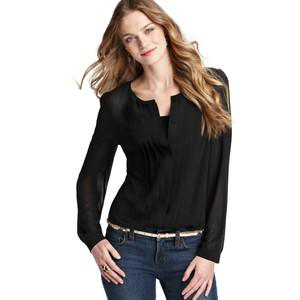

In [116]:
open_image(data_df_ouput.iloc[0, 0])

In [117]:
outfit_img_ids = [0]
outfits_selected = data_df_ouput.iloc[outfit_img_ids] 

_, _, similar_images_df = get_similar_images_annoy(annoy_tree, 0, 10)

5.814552307128906 ms


In [118]:
similar_images_df.reset_index(inplace=True)

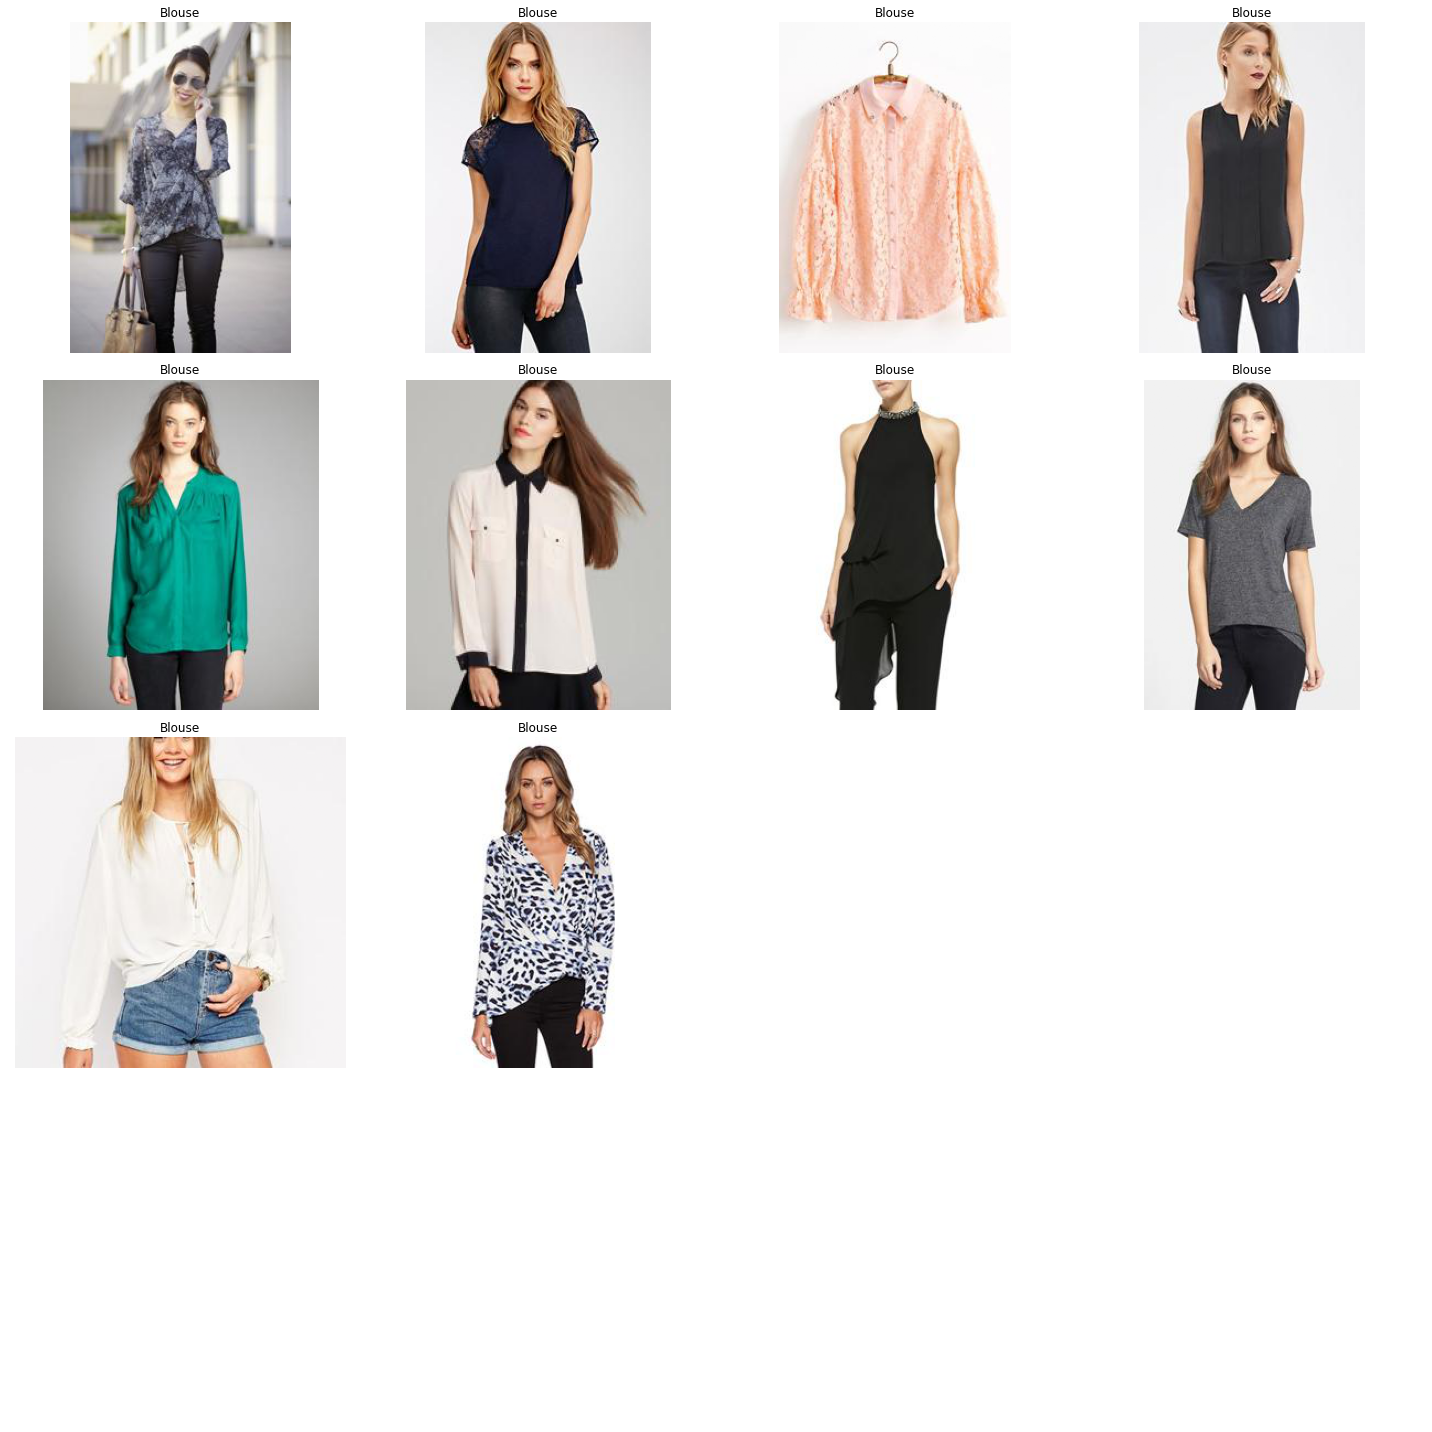

In [97]:
show_similar_images(similar_images_df, fig_size=[20,20])

### Example 2 - Party Dress

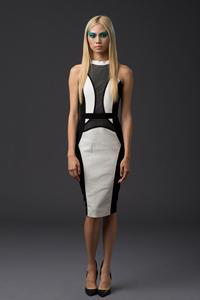

In [138]:
open_image(data_df_ouput.iloc[143800, 0])

In [139]:
outfit_img_ids = [143800]
outfits_selected = data_df_ouput.iloc[outfit_img_ids] 

_, _, similar_images_df = get_similar_images_annoy(annoy_tree, 143800, 10)

16.090869903564453 ms


In [140]:
similar_images_df.reset_index(inplace=True)

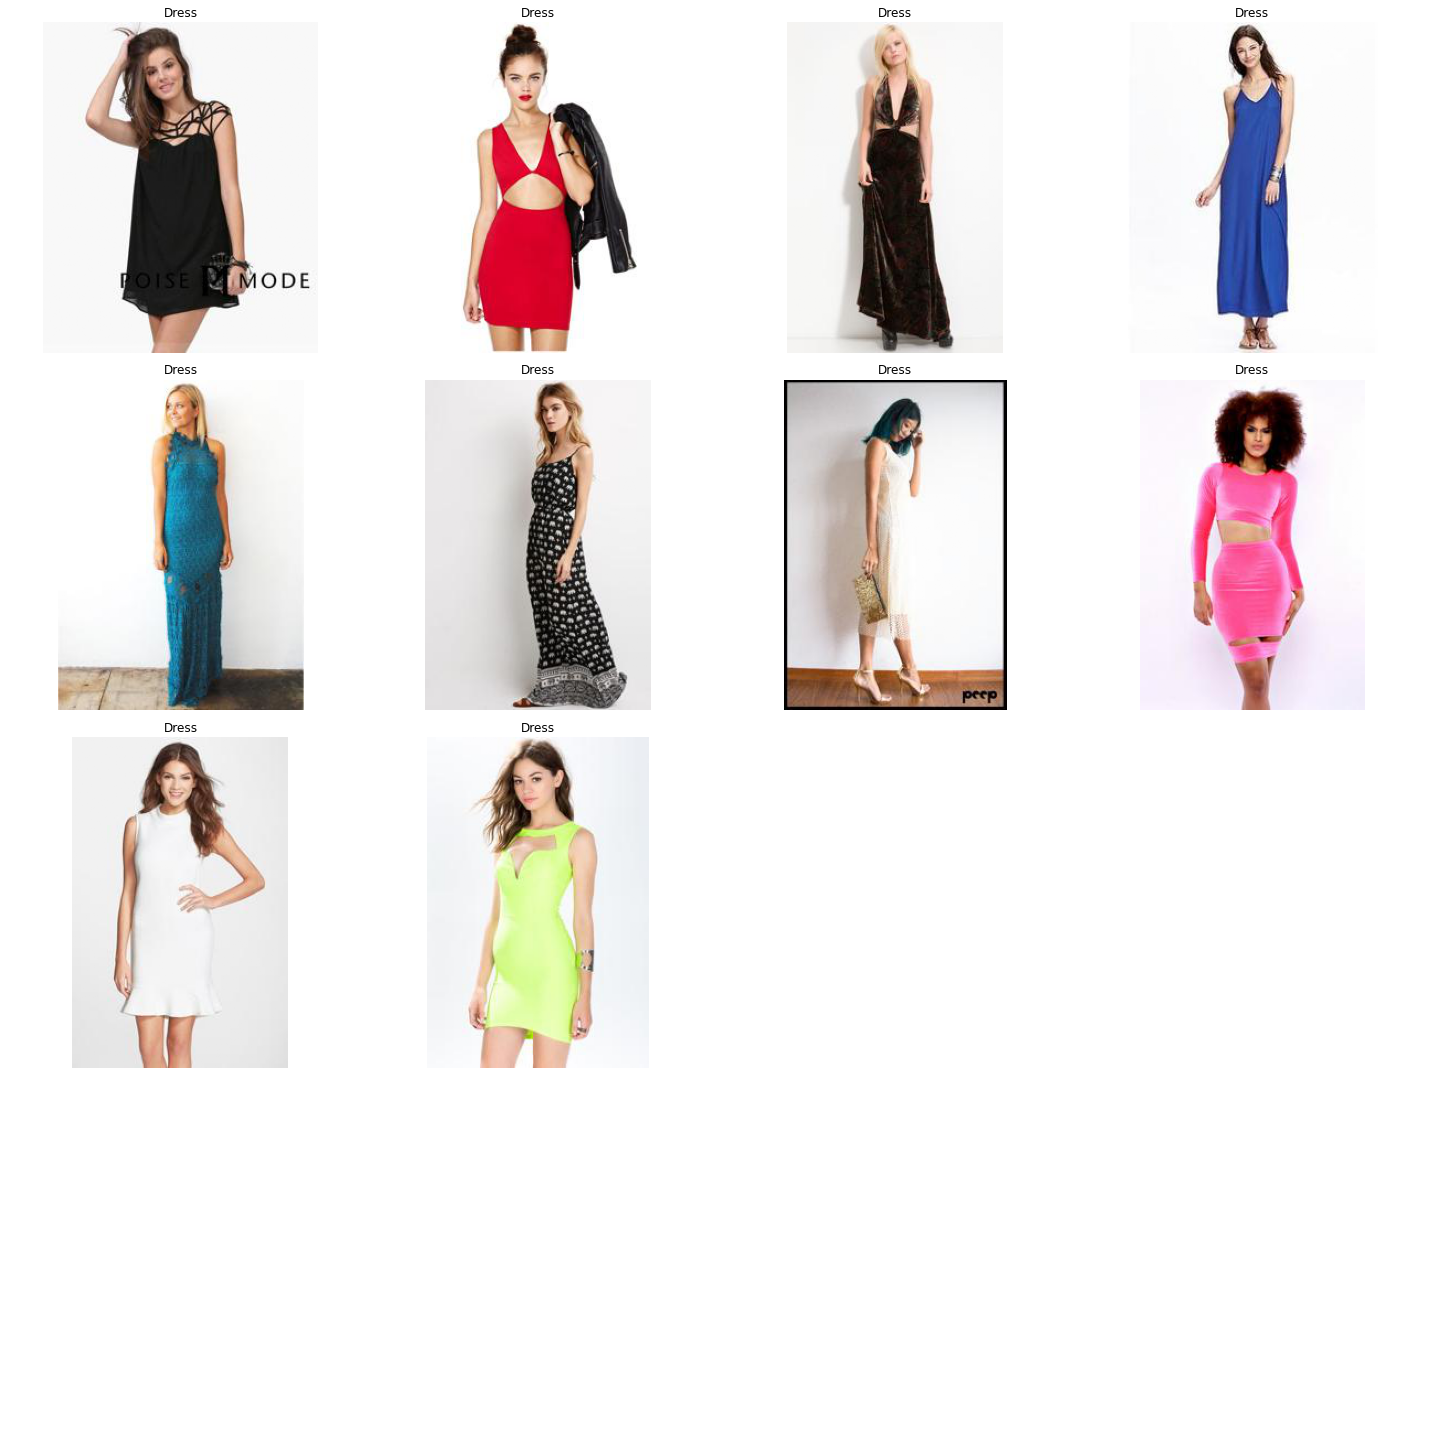

In [147]:
show_similar_images(similar_images_df, fig_size=[20,20])